# Zee Case Study (Recommder Systems)

# Problem Statement 

Create a Recommender System to show personalized movie recommendations based 
on ratings given by a user and other users similar to them in order to improve user experience.

## Data Dictionary:

### RATINGS FILE DESCRIPTION

=========================================================================

All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Timestamp is represented in seconds

Each user has at least 20 ratings

USERS FILE DESCRIPTION

=========================================================================

User information is in the file "users.dat" and is in the following format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female

Age is chosen from the following ranges:

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

Occupation is chosen from the following choices:

0: "other" or not specified

1: "academic/educator"

2: "artist"

3: "clerical/admin"

4: "college/grad student"

5: "customer service"

6: "doctor/health care"

7: "executive/managerial"

8: "farmer"

9: "homemaker"

10: "K-12 student"

11: "lawyer"

12: "programmer"

13: "retired"

14: "sales/marketing"

15: "scientist"

16: "self-employed"

17: "technician/engineer"

18: "tradesman/craftsman"

19: "unemployed"

20: "writer"

MOVIES FILE DESCRIPTION

=========================================================================

Movie information is in the file "movies.dat" and is in the following format:

MovieID::Title::Genres

Titles are identical to titles provided by the IMDB (including year of release)

Genres are pipe-separated and are selected from the following genres:

Action

Adventure

Animation

Children's

Comedy

Crime

Documentary

Drama

Fantasy

Film-Noir

Horror

Musical

Mystery

Romance

Sci-Fi

Thriller

War

Western

## Concepts Tested:

- Recommender Engine

- Collaborative Filtering (Item-based & User-based Approach)

- Pearson Correlation

- Nearest Neighbors using Cosine Similarity

- Matrix Factorization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn import metrics
%matplotlib inline


In [2]:
movies = pd.read_fwf("zee-movies.dat", encoding='ISO-8859-1')
ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [3]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [4]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [5]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [6]:
#The data is not in the correct format to use, 
#Changing the datasets and splitting the data and columns, to get the appropriate data frames.

In [7]:
movies = movies["Movie ID::Title::Genres"].str.split("::" , expand = True)
movies.columns = "Movie ID::Title::Genres".split("::")
users = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::" , expand = True)
users.columns = "UserID::Gender::Age::Occupation::Zip-code".split("::")
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split("::" , expand = True)
ratings.columns = 'UserID::MovieID::Rating::Timestamp'.split("::")

# Statistical Summary

In [8]:
movies.describe()

,Movie ID,Title,Genres
count,3883,3883,3858
unique,3883,3883,360
top,1,Toy Story (1995),Drama
freq,1,1,830


In [9]:
movies.dropna(inplace = True)
movies.isnull().sum()
movies["genres"] = movies["Genres"].str.split("|" , expand = False)
movies["Movie ID"] = movies["Movie ID"].astype(int)

In [10]:
def cleangenres(x):
    if x == "None":
        x = np.nan
    else:
        for i in range(len(x)):
            if x[i] in ["" , "A" , "Acti"]:
                x[i] = "Action"
            if x[i] in ['Adv', 'Advent', 'Adventu', 'Adventur']:
                x[i]  = "Adventure"
            if x[i] in ["Animati"]:
                x[i]  = "Animation"
            if x[i] in ['Chi', 'Chil', 'Childr', 'Childre','Children', "Children''", "Children's" ,"Children'"]:
                x[i]  = "Children"

            if x[i] in ['Com', 'Come', 'Comed']:
                x[i]  = "Comedy"
            if x[i] in ['D', 'Docu', 'Documen', 'Document', 'Documenta', 'Documentary']:
                x[i]  = "Documentary"
            if x[i] in ['Dr', 'Dram', 'Drama']:
                x[i]  = "Drama"
            if x[i] in ['F', 'Fant', 'Fantas', 'Fantasy']:
                x[i]  = "Fantasy"

            if x[i] in ['R', 'Ro','Rom', 'Roma', 'Roman', 'Romance']:
                x[i]  = "Romance"

            if x[i] in ['Music', 'Musical']:
                x[i]  = "Musical"

            if x[i] in ['Horr', 'Horro', 'Horror']:
                x[i]  = "Horror"


            if x[i] in ['S', 'Sci', 'Sci-', 'Sci-F','Sci-Fi']:
                x[i]  = "Sci-Fi"

            if x[i] in ['Th', 'Thri', 'Thrille']:
                x[i]  = "Thriller"

            if x[i] in ['We','Wester', 'Western']:
                x[i]  = "Western"
            if x[i] in ['Wa', 'War']:
                x[i]  = "War"
            else:
                continue
        return x
    

In [11]:
movies["Genres"] = movies['genres'].apply(cleangenres)
movies.drop("genres" , inplace = True , axis =1)

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3858 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3858 non-null   int64 
 1   Title     3858 non-null   object
 2   Genres    3858 non-null   object
dtypes: int64(1), object(2)
memory usage: 120.6+ KB


In [13]:
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [14]:
users.describe()

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25,4,48104
freq,1,4331,2096,759,19


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [16]:
ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [18]:
ratings["MovieID"] = ratings["MovieID"].astype(int)

In [19]:
movies.shape , ratings.shape, users.shape

((3858, 3), (1000209, 4), (6040, 5))

## Statistical Analysis Observations/Insights on the basis of Individual Data Frames

- Data was required to be converted into readable form as it was not a csv file.
- All the column are presented as Object Values, it needs to be changed according to Business Logic.



### Movies Data Frame :

- No duplicate values in movies data frame
- Cleaned the Genre column as few Genres were incorrect and spelling were wrong.

### Users Data Frame : 
- Gender , Age , Occupation are categorical values with 2 , 7 , 21 unique values.
- No Duplicate values for user_id

### Rating Data Frame :
- Timestamp type is object, which needs to be converted.
- Highest value in rating is 5.
- Rating is categorical and ordinal.

----> **There are no Null Values in the Data**



# Preprocessing, Exploratory Data Analysis and Feature Engineering
## Consolidated Data Frame

In [20]:
df = pd.merge(left=ratings , right = users , left_on = "UserID" , right_on ="UserID" )
df = pd.merge(left=df , right = movies , left_on = "MovieID" , right_on ="Movie ID" )
df.drop("Movie ID" , axis = 1 , inplace = True)
df["Age"] = df["Age"].astype("int")
df["Occupation"] = df["Occupation"].astype("int")
df["Gender"]  = df["Gender"].apply(lambda x : 1 if x=="F" else 0)
df["hours"] = df["Timestamp"].astype("int").apply(lambda x : datetime.fromtimestamp(x).hour)
df["year"] = df["Timestamp"].astype("int").apply(lambda x : datetime.fromtimestamp(x).year)
df["month"] = df["Timestamp"].astype("int").apply(lambda x : datetime.fromtimestamp(x).month)
df["Rating"] = df["Rating"].astype("int")
df["UserID"] = df["UserID"].astype("int")
df["MovieID"] = df["MovieID"].astype("int")
df.dropna(inplace = True)

In [21]:
def ExtractReleaseYear(x):
    y= x.split("(")
    if len(y) == 2:
        return y[1][:-1]
    elif len(y)==3:
        return y[2][:-1]
    else:
        return np.nan

In [22]:
df["Release_Year"] = df["Title"].apply(ExtractReleaseYear).astype("int16")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   UserID        996144 non-null  int64 
 1   MovieID       996144 non-null  int64 
 2   Rating        996144 non-null  int64 
 3   Timestamp     996144 non-null  object
 4   Gender        996144 non-null  int64 
 5   Age           996144 non-null  int64 
 6   Occupation    996144 non-null  int64 
 7   Zip-code      996144 non-null  object
 8   Title         996144 non-null  object
 9   Genres        996144 non-null  object
 10  hours         996144 non-null  int64 
 11  year          996144 non-null  int64 
 12  month         996144 non-null  int64 
 13  Release_Year  996144 non-null  int16 
dtypes: int16(1), int64(9), object(4)
memory usage: 108.3+ MB


In [24]:
df.describe()

,UserID,MovieID,Rating,Gender,Age,Occupation,hours,year,month,Release_Year
count,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000,996144.000000
mean,3024.002930,1867.029726,3.579985,0.246505,29.726427,8.034997,9.730529,2000.126768,8.715070,1986.758458
std,1728.265045,1096.028575,1.116849,0.430976,11.748818,6.530667,7.293934,0.422907,2.719719,14.314470
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2000.000000,1.000000,1919.000000
25%,1505.000000,1032.000000,3.000000,0.000000,25.000000,2.000000,4.000000,2000.000000,7.000000,1982.000000
50%,3069.000000,1836.000000,4.000000,0.000000,25.000000,7.000000,8.000000,2000.000000,9.000000,1992.000000
75%,4476.000000,2770.000000,4.000000,0.000000,35.000000,14.000000,15.000000,2000.000000,11.000000,1997.000000
max,6040.000000,3952.000000,5.000000,1.000000,56.000000,20.000000,23.000000,2003.000000,12.000000,2000.000000


In [25]:
df.shape

(996144, 14)

In [68]:
df.isnull().sum()

UserID          0
MovieID         0
Rating          0
Timestamp       0
Gender          0
Age             0
Occupation      0
Zip-code        0
Title           0
Genres          0
hours           0
year            0
month           0
Release_Year    0
dtype: int64

## Consolidated Data Frame

- There are no null values in the data frame.
- We have extracted , Release Year for movies. Hour, Year,Month of the time of ratings werre given.
- Few columns are converted to int

## Distributions for Numerical Columns 

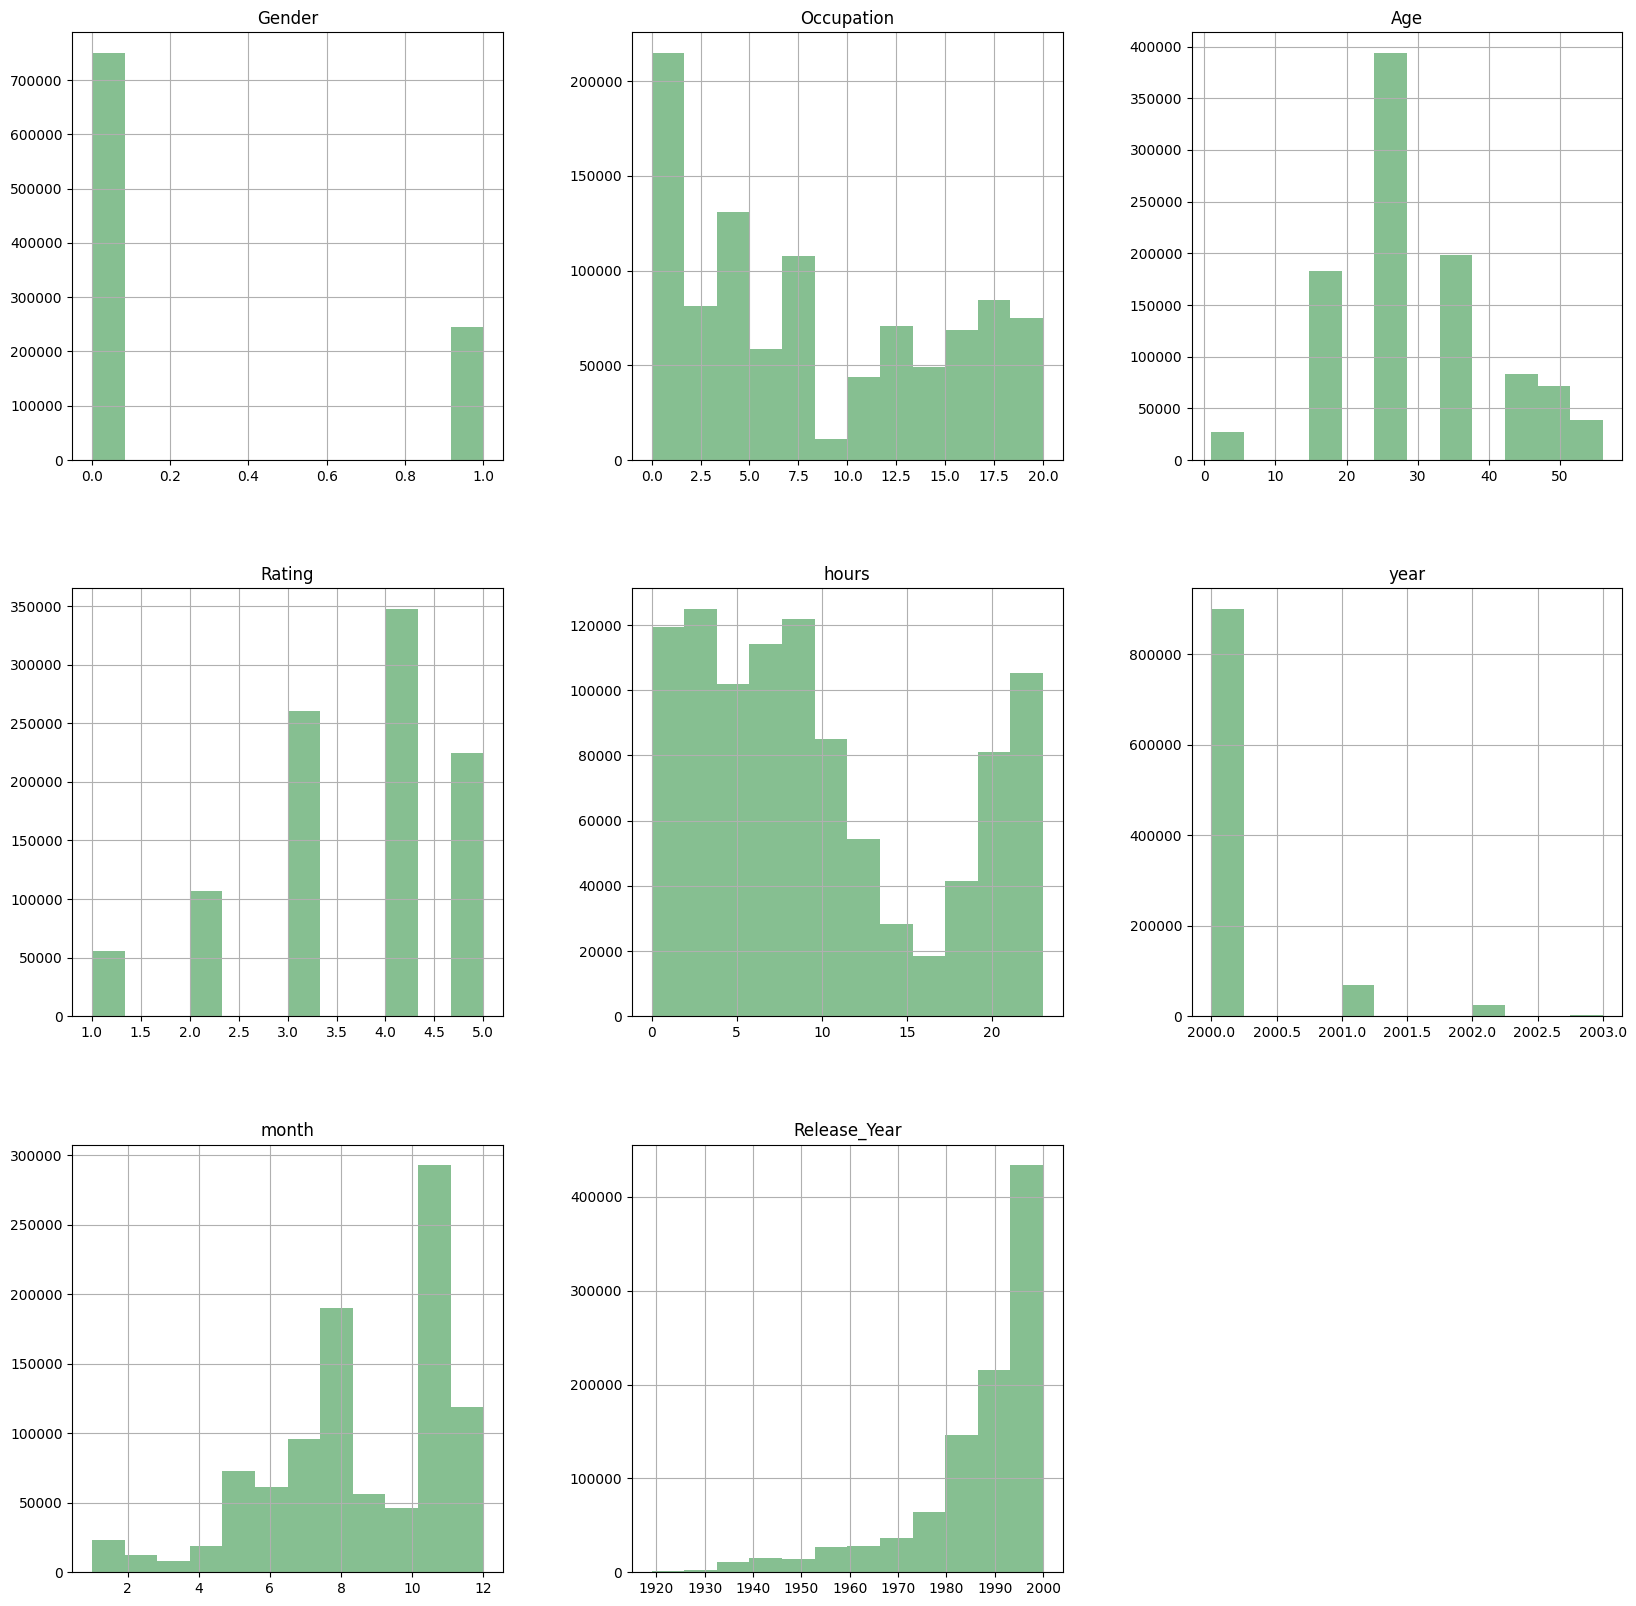

In [27]:
df.hist(column=["Gender" , "Occupation" , "Age" , "Rating" , "hours" , "year" , "month" , "Release_Year"] ,grid = True, color='#86bf91', bins = 12, figsize=(20,20))
plt.show()

<Axes: xlabel='Age', ylabel='count'>

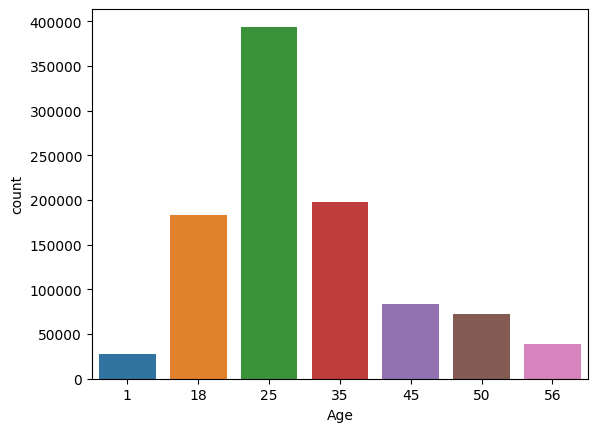

In [62]:
sns.countplot(x = df["Age"])

In [28]:
def groupbyfunction(x , figursize):
    fig, axes = plt.subplots(2,2 , figsize = figursize)
    df.groupby(x)["Rating"].count().sort_values(ascending = False).head(5).plot(kind = "bar" ,  ax = axes[0,0] , color= "brown")
    print("Top 5 count",x,":", df.groupby(x)["Rating"].count().sort_values(ascending = False).head(5).index,"\n")
    
    df.groupby(x)["Rating"].count().sort_values(ascending = False).tail(5).plot(kind = "bar" ,  ax = axes[0,1] , color= "brown")
    print("Bottom 5 count",x,":", df.groupby(x)["Rating"].count().sort_values(ascending = False).tail(5).index,"\n")
    

    df.groupby(x)["Rating"].mean().sort_values(ascending = False).head(5).plot(kind = "bar" ,  ax = axes[1,0], color= "brown")
    print("Top 5 mean",x,":", df.groupby(x)["Rating"].mean().sort_values(ascending = False).head(5).index,"\n")


    df.groupby(x)["Rating"].mean().sort_values(ascending = False).tail(5).plot(kind = "bar" ,  ax = axes[1,1], color= "brown")
    print("Bottom 5 mean",x,":", df.groupby(x)["Rating"].mean().sort_values(ascending = False).tail(5).index,"\n")


    
    

Top 5 count UserID : Int64Index([4169, 1680, 4277, 1941, 1181], dtype='int64', name='UserID') 

Bottom 5 count UserID : Int64Index([3021, 3222, 5533, 5258, 3324], dtype='int64', name='UserID') 

Top 5 mean UserID : Int64Index([3324, 283, 2339, 3902, 446], dtype='int64', name='UserID') 

Bottom 5 mean UserID : Int64Index([5850, 4539, 2744, 4486, 3598], dtype='int64', name='UserID') 



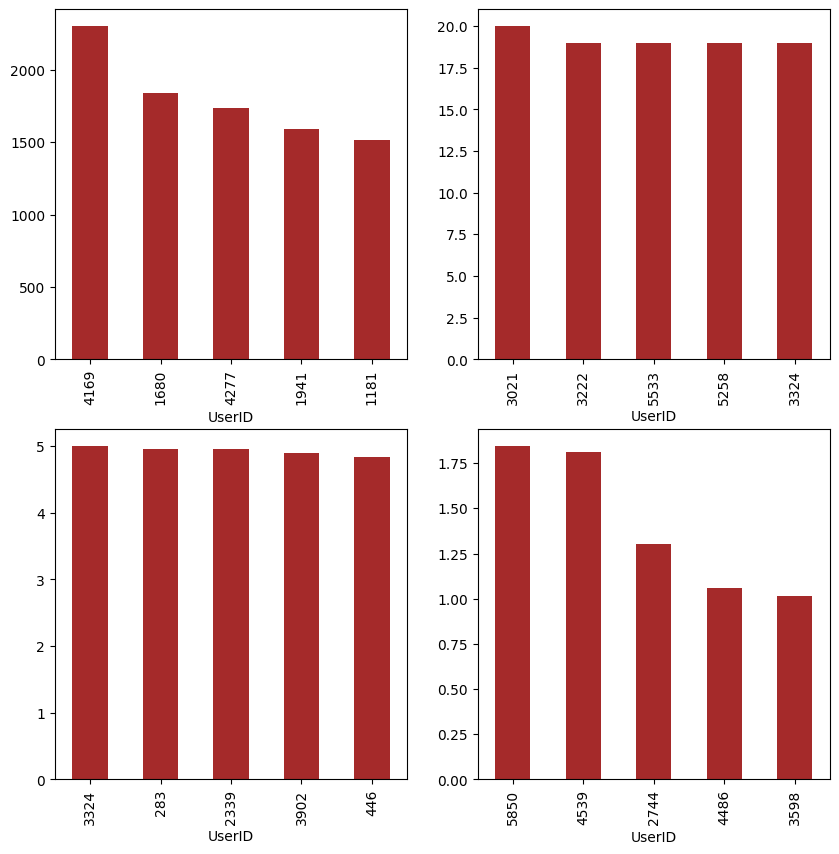

In [29]:
groupbyfunction("UserID" , (10,10))

Top 5 count Title : Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='Title') 

Bottom 5 count Title : Index(['Joyriders, The (1999)', 'White Boys (1999)',
       'Voyage to the Beginning of the World (1997)', 'Lured (1947)',
       'Back Stage (2000)'],
      dtype='object', name='Title') 

Top 5 mean Title : Index(['Song of Freedom (1936)', 'Schlafes Bruder (Brother of Sleep) (1995)',
       'Ulysses (Ulisse) (1954)', 'Lured (1947)', 'Bittersweet Motel (2000)'],
      dtype='object', name='Title') 

Bottom 5 mean Title : Index(['Get Over It (1996)', 'Underworld (1997)', 'Waltzes from Vienna (1933)',
       'Sleepover (1995)', 'Lotto Land (1995)'],
      dtype='object', name='Title') 



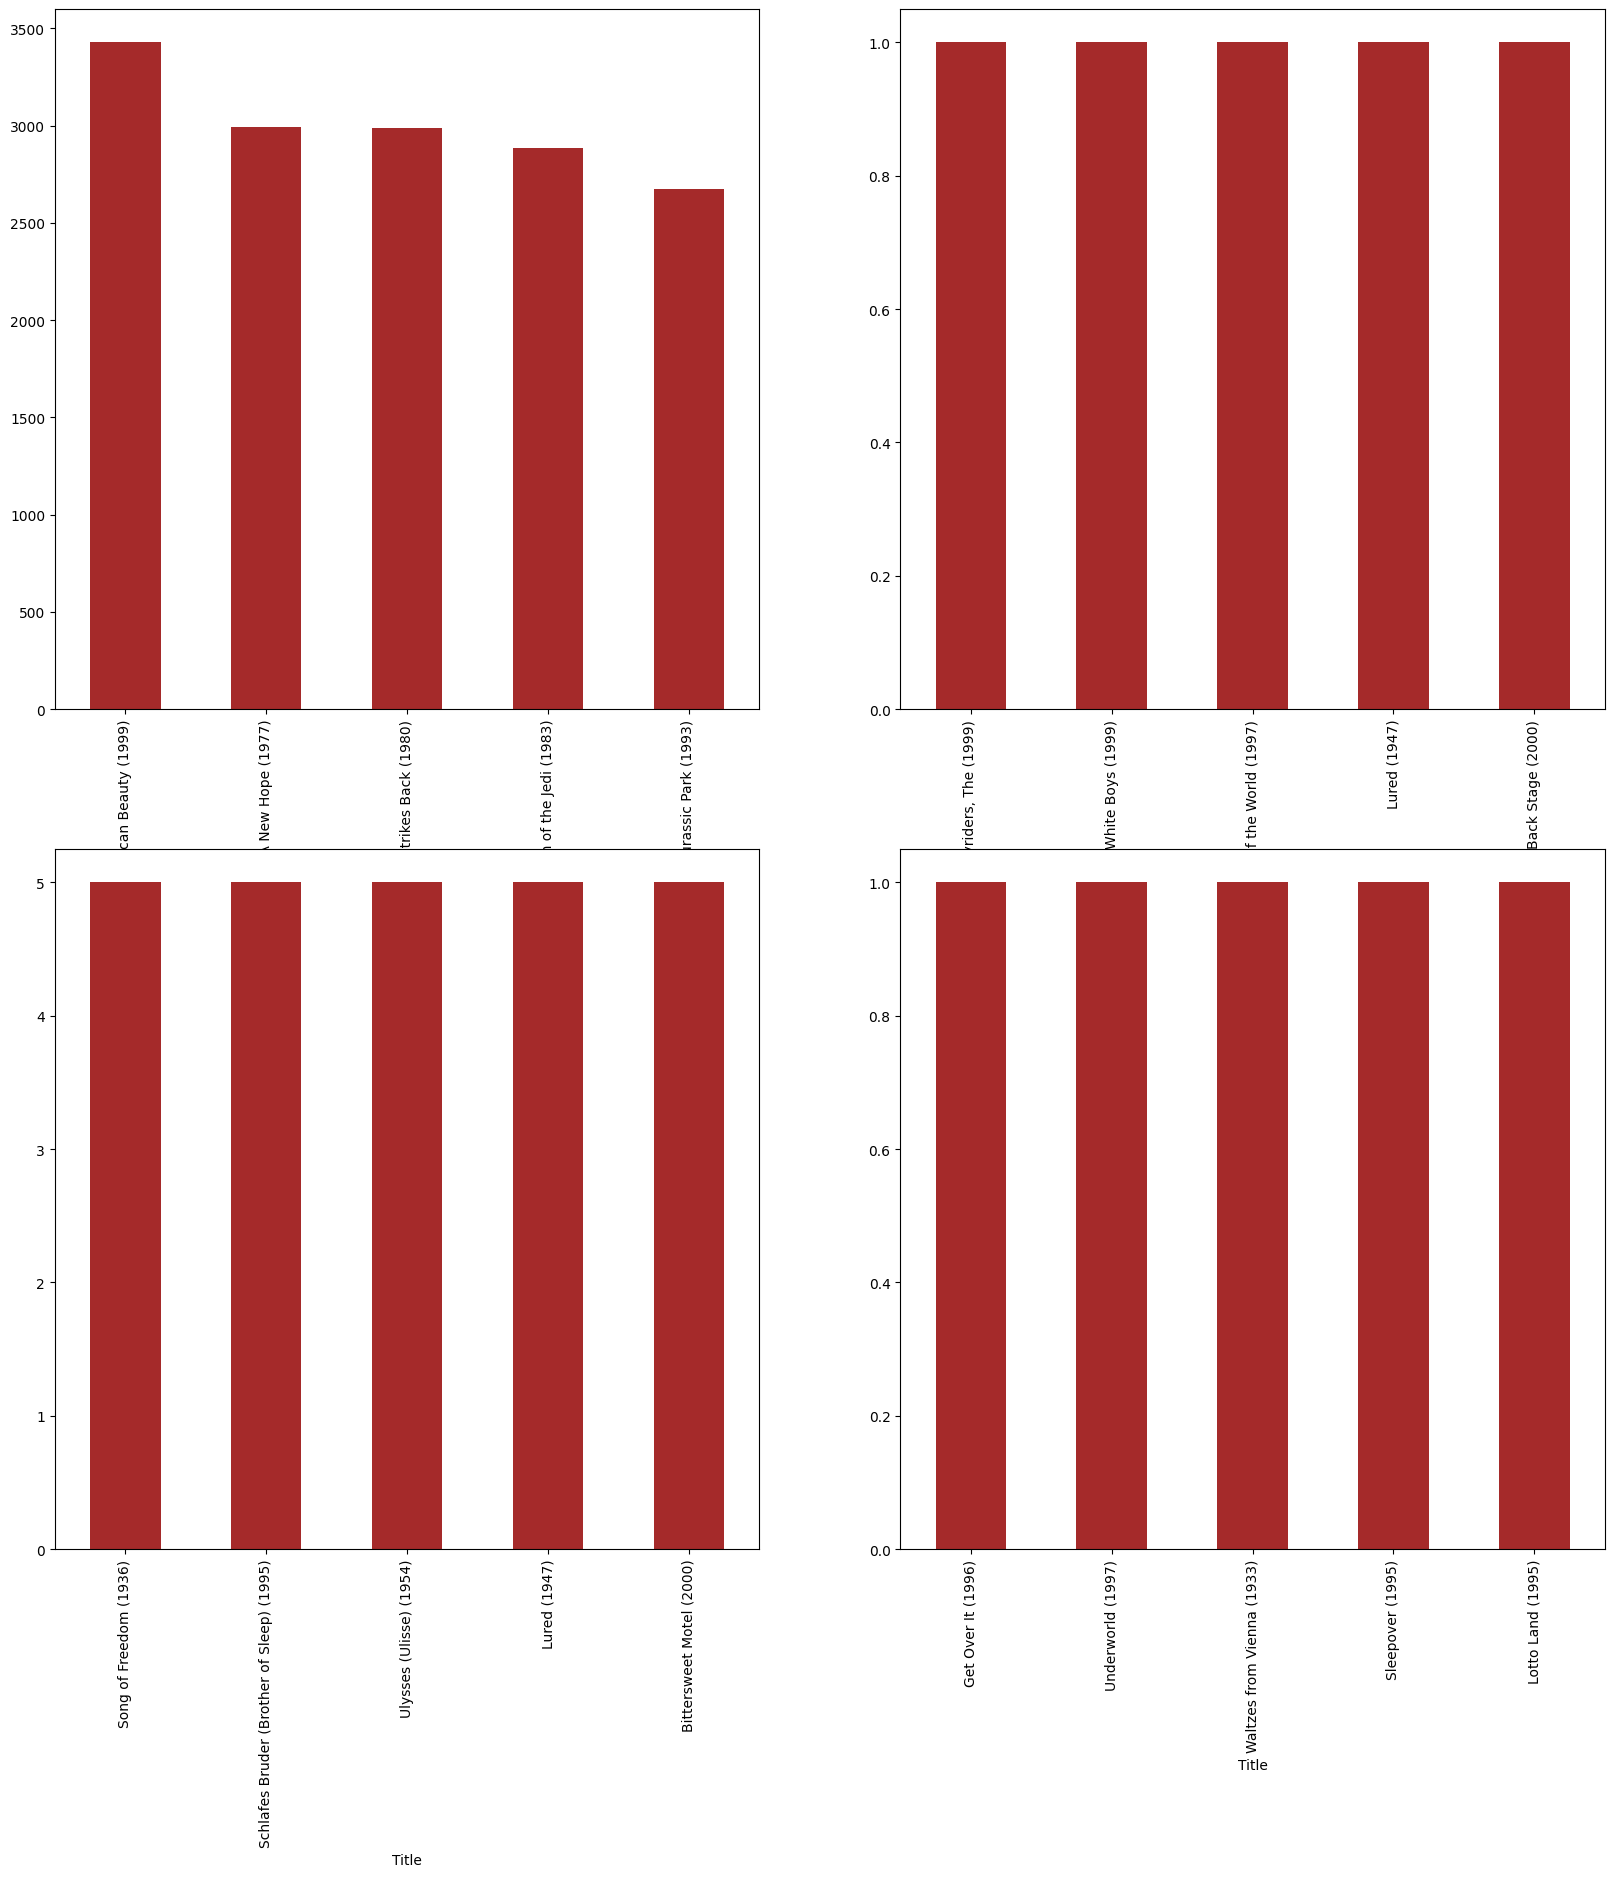

In [30]:
groupbyfunction("Title" , (20,20))

Top 5 count Occupation : Int64Index([4, 0, 7, 1, 17], dtype='int64', name='Occupation') 

Bottom 5 count Occupation : Int64Index([19, 13, 18, 9, 8], dtype='int64', name='Occupation') 

Top 5 mean Occupation : Int64Index([13, 15, 6, 9, 3], dtype='int64', name='Occupation') 

Bottom 5 mean Occupation : Int64Index([10, 18, 20, 8, 19], dtype='int64', name='Occupation') 



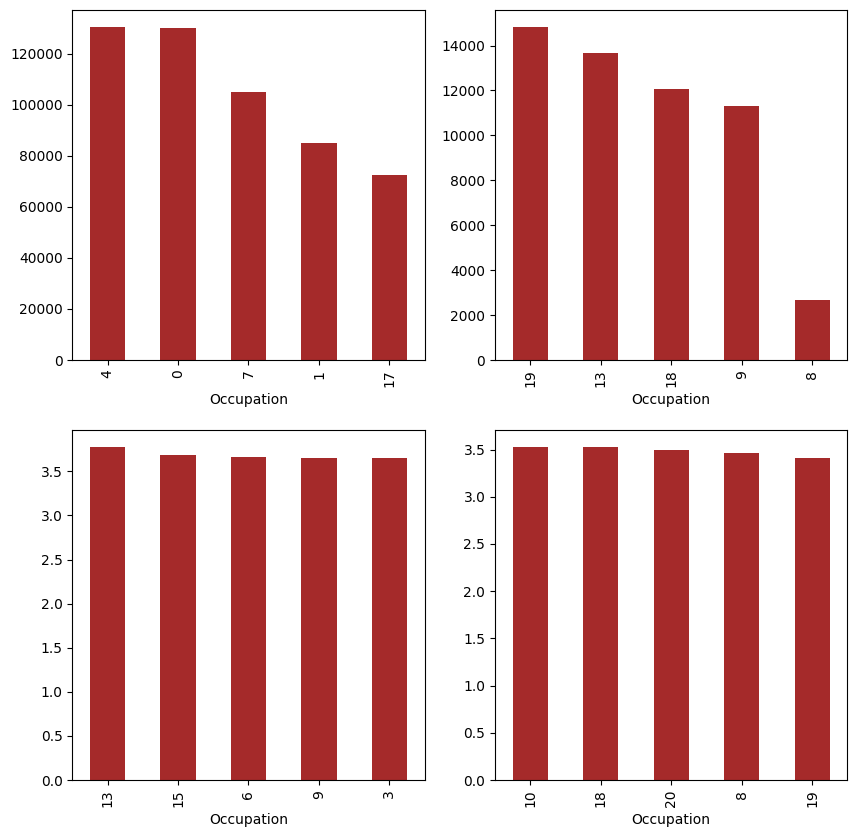

In [31]:
groupbyfunction("Occupation" , (10,10))

Top 5 count Age : Int64Index([25, 35, 18, 45, 50], dtype='int64', name='Age') 

Bottom 5 count Age : Int64Index([18, 45, 50, 56, 1], dtype='int64', name='Age') 

Top 5 mean Age : Int64Index([56, 50, 45, 35, 1], dtype='int64', name='Age') 

Bottom 5 mean Age : Int64Index([45, 35, 1, 25, 18], dtype='int64', name='Age') 



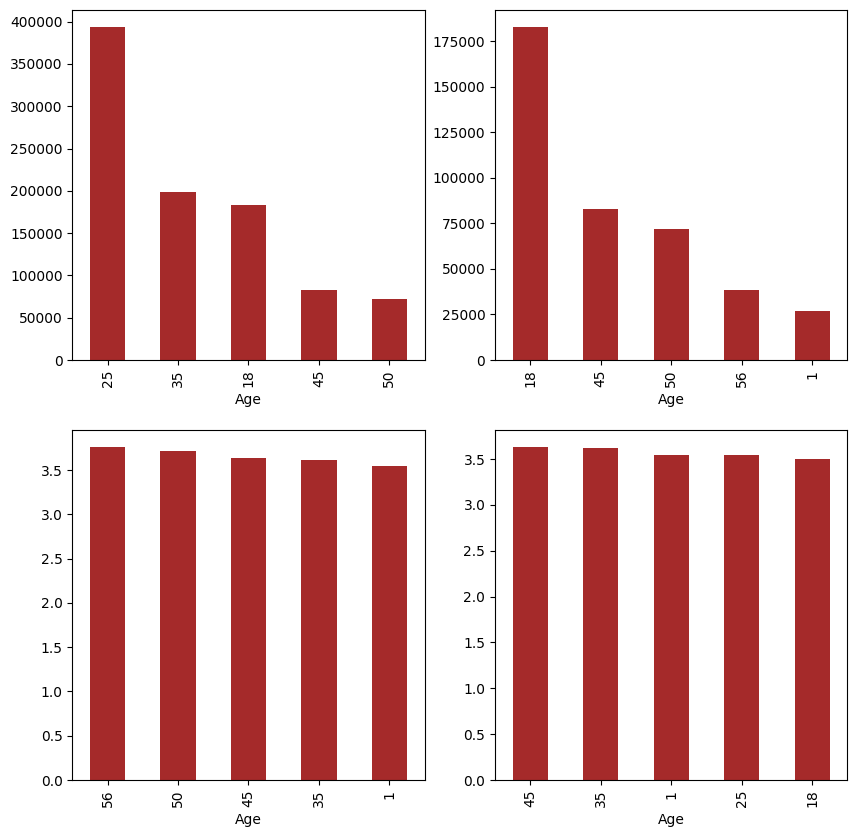

In [32]:
groupbyfunction("Age" , figursize=(10,10))

<Axes: xlabel='Occupation', ylabel='count'>

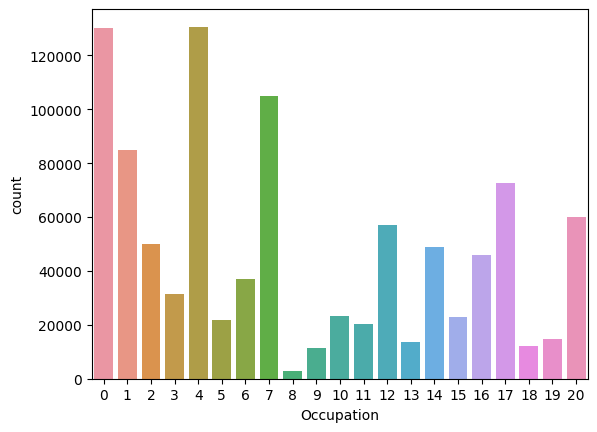

In [33]:
sns.countplot(x = df["Occupation"])

In [34]:
df.groupby("Gender")["Rating"].mean()

Gender
0    3.567107
1    3.619351
Name: Rating, dtype: float64

<Axes: >

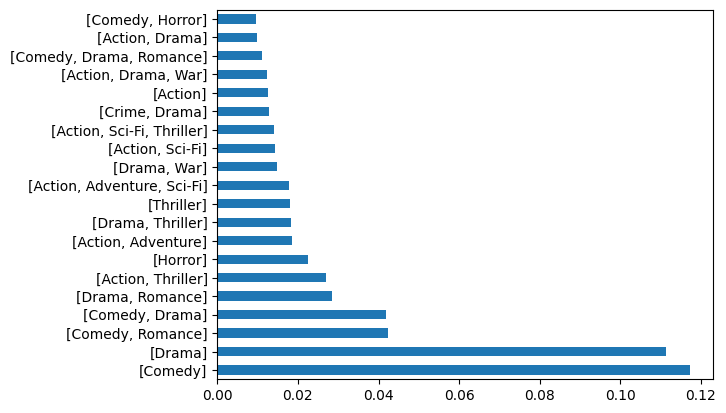

In [35]:
df["Genres"].value_counts(normalize=True).head(20).plot(kind = "barh")

<Axes: >

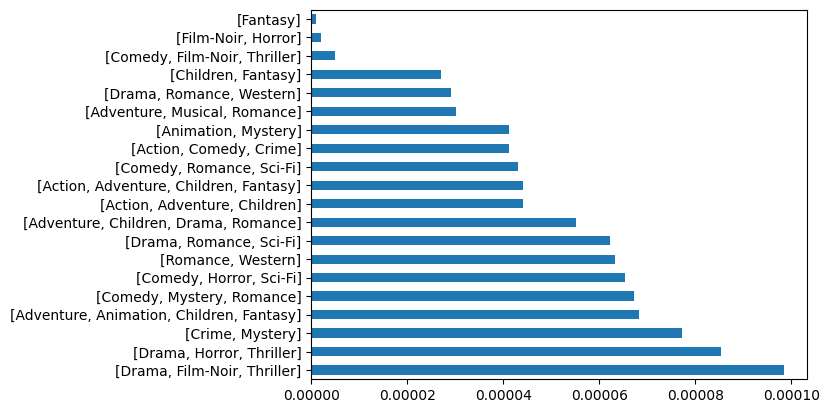

In [36]:
df["Genres"].value_counts(normalize=True).tail(20).plot(kind = "barh")

# **RECOMMENDER SYSTEM**

## Cosine Similarity with Users

In [37]:
u=df.groupby(["UserID","Gender" , "Age" , "Occupation"])["Rating" , "hours" , "month" , "year"].mean().reset_index()
u.index = u["UserID"]
u.drop("UserID" , inplace = True , axis = 1) 

/var/folders/8d/h5wxclqj6mq4pjjkr0kf78780000gn/T/ipykernel_22460/621803254.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  u=df.groupby(["UserID","Gender" , "Age" , "Occupation"])["Rating" , "hours" , "month" , "year"].mean().reset_index()


In [38]:
pd.DataFrame(data = metrics.pairwise.cosine_similarity(u), index=u.index , columns= u.index)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.999618,0.999925,0.999756,0.999892,0.999681,0.999827,0.999910,0.999906,0.999836,...,0.999948,0.999754,0.999696,0.999924,0.999916,0.999917,0.999746,0.999610,0.999744,0.999918
2,0.999618,1.000000,0.999880,0.999974,0.999854,0.999969,0.999897,0.999860,0.999864,0.999907,...,0.999784,0.999971,0.999991,0.999877,0.999849,0.999871,0.999954,0.999970,0.999951,0.999858
3,0.999925,0.999880,1.000000,0.999942,0.999971,0.999895,0.999942,0.999980,0.999982,0.999952,...,0.999960,0.999937,0.999917,0.999997,0.999972,0.999989,0.999921,0.999853,0.999919,0.999979
4,0.999756,0.999974,0.999942,1.000000,0.999900,0.999972,0.999960,0.999926,0.999919,0.999971,...,0.999896,0.999993,0.999987,0.999940,0.999940,0.999929,0.999990,0.999976,0.999990,0.999936
5,0.999892,0.999854,0.999971,0.999900,1.000000,0.999906,0.999941,0.999990,0.999995,0.999938,...,0.999934,0.999919,0.999905,0.999983,0.999943,0.999989,0.999894,0.999822,0.999887,0.999969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.999917,0.999871,0.999989,0.999929,0.999989,0.999909,0.999954,0.999989,0.999989,0.999957,...,0.999965,0.999941,0.999919,0.999997,0.999973,1.000000,0.999924,0.999852,0.999918,0.999990
6037,0.999746,0.999954,0.999921,0.999990,0.999894,0.999980,0.999979,0.999927,0.999910,0.999984,...,0.999909,0.999995,0.999979,0.999929,0.999950,0.999924,1.000000,0.999985,1.000000,0.999945
6038,0.999610,0.999970,0.999853,0.999976,0.999822,0.999977,0.999935,0.999856,0.999840,0.999941,...,0.999819,0.999980,0.999977,0.999859,0.999880,0.999852,0.999985,1.000000,0.999985,0.999873


## Cosine Similarity with Items


In [39]:
m = movies.copy()
m = m.explode("Genres")
m.drop_duplicates(inplace=True)
m = pd.pivot(data = m , index='Movie ID', columns='Genres' , values="Title")
m = ~m.isna()
m = m.astype(int)
m = m.reset_index()
m

Genres,Movie ID,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3854,3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3855,3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3856,3951,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [40]:
m = m.merge(df.groupby("MovieID")["Rating"].mean() , how = "inner" , left_on="Movie ID" , right_on="MovieID")
m.columns

Index(['Movie ID', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'Rating'],
      dtype='object')

In [41]:
pd.DataFrame(data = metrics.pairwise.cosine_similarity(m), index=m["Movie ID"] , columns=m["Movie ID"] )

Movie ID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.851178,0.799852,0.702599,0.677668,0.652501,0.607722,0.538955,0.460726,0.498762,...,0.217957,0.217742,0.217655,0.217721,0.217997,0.218089,0.218143,0.218041,0.218094,0.218067
2,0.851178,1.000000,0.840896,0.798880,0.798297,0.799732,0.758135,0.768344,0.676283,0.724333,...,0.482178,0.481994,0.481994,0.482022,0.482259,0.482291,0.482384,0.482296,0.482342,0.482318
3,0.799852,0.840896,1.000000,0.938822,0.944655,0.901137,0.938195,0.851853,0.827581,0.844165,...,0.669715,0.669555,0.669392,0.669523,0.669730,0.669814,0.669839,0.669762,0.669802,0.669781
4,0.702599,0.798880,0.938822,1.000000,0.978037,0.932591,0.959531,0.920248,0.908496,0.915882,...,0.793369,0.793291,0.793105,0.793261,0.793376,0.793449,0.793514,0.793453,0.793484,0.793468
5,0.677668,0.798297,0.944655,0.978037,1.000000,0.957376,0.987352,0.956522,0.948544,0.953138,...,0.845100,0.844979,0.844856,0.844955,0.845111,0.845175,0.845193,0.845136,0.845166,0.845150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.218089,0.482291,0.669814,0.793449,0.845175,0.816646,0.884937,0.923536,0.953941,0.930644,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3949,0.218143,0.482384,0.669839,0.793514,0.845193,0.816710,0.884957,0.923578,0.953975,0.930684,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3950,0.218041,0.482296,0.669762,0.793453,0.845136,0.816650,0.884908,0.923539,0.953943,0.930647,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Pearson Correlation Recommender System

In [42]:
pivot_user_item = pd.pivot_table(data=df , index = df["UserID"] , columns=df["MovieID"] ,values = "Rating").fillna(0)
pivot_user_item

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
sparse_value = pivot_user_item[pivot_user_item==0].count().sum()/(pivot_user_item.shape[0]*pivot_user_item.shape[1])
sparse_value

0.9552079024141069

In [44]:
pd.DataFrame(data = pivot_user_item.corrwith(pivot_user_item[1]).sort_values(ascending=False).head(10),columns=["corr"]).reset_index().merge(movies , how = "inner" , left_on="MovieID" , right_on="Movie ID").drop("Movie ID" , axis = 1)

,MovieID,corr,Title,Genres
0,1,1.000000,Toy Story (1995),"[Animation, Children, Comedy]"
1,3114,0.487370,Toy Story 2 (1999),"[Animation, Children, Comedy]"
2,588,0.470753,Aladdin (1992),"[Animation, Children, Comedy, Musical]"
3,364,0.411131,"Lion King, The (1994)","[Animation, Children, Musical]"
4,1265,0.407547,Groundhog Day (1993),"[Comedy, Romance]"
5,2355,0.402679,"Bug's Life, A (1998)","[Animation, Children, Comedy]"
6,595,0.395510,Beauty and the Beast (1991),"[Animation, Children, Musical]"
7,34,0.378794,Babe (1995),"[Children, Comedy, Drama]"
8,3253,0.370424,Wayne's World (1992),[Comedy]
9,1923,0.357726,There's Something About Mary (1998),[Comedy]


## Matrix Factorization Systems

In [45]:
rm_raw = df[['UserID', 'MovieID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,2,1193,5


In [60]:
movies

,Movie ID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


## **Questionnaire:**

Users of which age group have watched and rated the most number of movies?
- Between 25

Users belonging to which profession have watched and rated the most movies?
- 0,4,7 (Other , Students , executives)

Most of the users in our dataset who’ve rated the movies are Male. (T/F)
- True

Most of the movies present in our dataset were released in which decade?
- 90's

The movie with maximum no. of ratings is ___.
- American Beauty

On the basis of approach, Collaborative Filtering methods can be classified into item based and user based.

Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between 0 to 1.

Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
- RSME = 1.4681938747852086
- MAPE = 0.4182823520002578



## Actionable Insights

Ratings are provided mostly by men.

Users are usually generous as mostly they have provided ratings between 3-4.

Rating 1-2 have been given very few times.

Users watch movies usually between 12 am to 2 am.

Less traffic is on the website during 11-5 i.e Corporate hours.

Mostly rating are presented between October, November , December.

There is a high rise in the movies released in 1990's.

People of Age 25 and 35 give highest number of ratings, whereas people over 45 hardly rate.

Top 5 count UserID : Int64Index([4169, 1680, 4277, 1941, 1181]

Bottom 5 count UserID : Int64Index([3021, 3222, 5533, 5258, 3324]

Top 5 mean UserID : Int64Index([3324, 283, 2339, 3902, 446]

Bottom 5 mean UserID : Int64Index([5850, 4539, 2744, 4486, 3598]

Top 5 count Title : Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)']
                          
Bottom 5 count Title : Index(['Joyriders, The (1999)', 'White Boys (1999)',
       'Voyage to the Beginning of the World (1997)', 'Lured (1947)',
       'Back Stage (2000)']
                             
Top 5 mean Title : Index(['Song of Freedom (1936)', 'Schlafes Bruder (Brother of Sleep) (1995)',
       'Ulysses (Ulisse) (1954)', 'Lured (1947)', 'Bittersweet Motel (2000)'],

Bottom 5 mean Title : Index(['Get Over It (1996)', 'Underworld (1997)', 'Waltzes from Vienna (1933)',
       'Sleepover (1995)', 'Lotto Land (1995)']                                  
Top 5 count Occupation : Int64Index([4, 0, 7, 1, 17]

Bottom 5 count Occupation : Int64Index([19, 13, 18, 9, 8]

Top 5 mean Occupation : Int64Index([13, 15, 6, 9, 3]
                                   
Bottom 5 mean Occupation : Int64Index([10, 18, 20, 8, 19]
                                      
College students are highly active on the platform.
                                      
Farmers, retired and Craftsmen are the few professions which do not use the Platform alot.
                                      
There is no difference between the mean rating of Male vs Female.
                                      
Most movies belong to Comedy and Drama.

Performed Recommender System using Cosine Similarity with respect to Item and User.

Performed Recommender System using Pearson Correlation.

Observed that the pivot for user vs matrix vs rating will be very sparse.
Only 5 percent data is present.

Performed Matrix Factorizations for recommending.






# Recommendations

1. Zee should encourage users to provide more ratings, espcially women.
2. Recommender systems based on users and item work well with zee.
3. Due to the sparse pivot , between users and items and ratings , Matrrix Factorizations should be used.
4. Regression recommender systems can also be used. They can be more effective.
5. More Comedy and Drama should be recommended.